In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/llm-detect-ai-generated-text/sample_submission.csv
/kaggle/input/llm-detect-ai-generated-text/train_prompts.csv
/kaggle/input/llm-detect-ai-generated-text/test_essays.csv
/kaggle/input/llm-detect-ai-generated-text/train_essays.csv


# Problem Description

Recently large language models (LLMs) have become advanced and models like ChatGPT are able of generating text that is challenging to distinguish from that written by humans. The goal of this problem is to create transparency and encourage research on AI detection by looking at the real world and detecting AI techniques in environments like primary and secondary schools. It is increasingly prevalent that we see scenarios arise such that student assignments like school essays may contain paragraphs or even entire essays written entirely by AI instead of students themselves. Let's help to prevent plagiarism, while continuing to foster creativity and new types of learning using AI. The data has texts of moderate length and our goal again is to identify LLM artifacts and detect which texts are written by LLMs.

# Data Description

We have datasets with essays that are written by a combination of middle and high schools students, and some written using a large language model (LLM). These datasets are sourced from Kaggle at https://www.kaggle.com/competitions/llm-detect-ai-generated-text/data and the competition dataset comprises about 10,000 essays. The main dataset train_essays.csv is about 4.4 MB with 1378 rows and 4 columns, one of which contains the 'generated' feature that indicates 1 for essays written by LLMs and 0 for those written by humans.

# Load data

In [2]:
train = pd.read_csv('/kaggle/input/llm-detect-ai-generated-text/train_essays.csv')
test = pd.read_csv('/kaggle/input/llm-detect-ai-generated-text/test_essays.csv')
prompts = pd.read_csv('/kaggle/input/llm-detect-ai-generated-text/train_prompts.csv')
submission = pd.read_csv('/kaggle/input/llm-detect-ai-generated-text/sample_submission.csv')

# Exploratory Data Analysis (EDA)

In [3]:
train.head()

,id,prompt_id,text,generated
0,0059830c,0,Cars. Cars have been around since they became ...,0
1,005db917,0,Transportation is a large necessity in most co...,0
2,008f63e3,0,"""America's love affair with it's vehicles seem...",0
3,00940276,0,How often do you ride in a car? Do you drive a...,0
4,00c39458,0,Cars are a wonderful thing. They are perhaps o...,0


In [4]:
prompts.head()

,prompt_id,prompt_name,instructions,source_text
0,0,Car-free cities,Write an explanatory essay to inform fellow ci...,"# In German Suburb, Life Goes On Without Cars ..."
1,1,Does the electoral college work?,Write a letter to your state senator in which ...,# What Is the Electoral College? by the Office...


In [5]:
train['text'][0].count('\n')

6

In [6]:
train['text'] = train['text'].str.replace('\n', ' ')
test['text'] = test['text'].str.replace('\n', ' ')

## Imports

In [7]:

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.model_selection import train_test_split


from tokenizers import (
    decoders,
    models,
    normalizers,
    pre_tokenizers,
    trainers,
    Tokenizer,
)

from transformers import PreTrainedTokenizerFast

import gc


import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.metrics import AUC
from keras.callbacks import EarlyStopping
from keras.models import load_model



In [8]:
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

In [9]:
train.head()

,id,prompt_id,text,generated
0,0059830c,0,Cars. Cars have been around since they became ...,0
1,005db917,0,Transportation is a large necessity in most co...,0
2,008f63e3,0,"""America's love affair with it's vehicles seem...",0
3,00940276,0,How often do you ride in a car? Do you drive a...,0
4,00c39458,0,Cars are a wonderful thing. They are perhaps o...,0


In [10]:

print("Generated By LLM :",train[train['generated']==1].shape[0])
print("Written by a Student :",train[train['generated']==0].shape[0])


Generated By LLM : 3
Written by a Student : 1375


In [11]:
written_human=train[train['generated']==0]
written_LLM=train[train['generated']==1]

<Axes: >

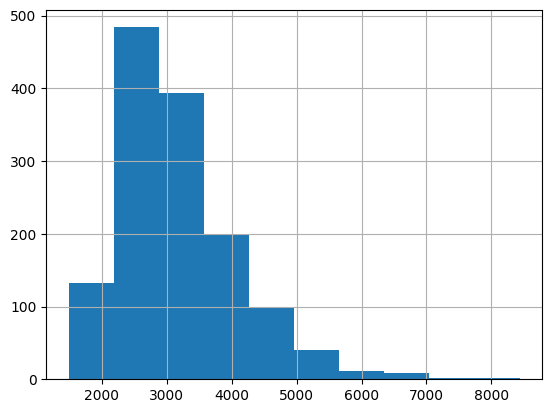

In [12]:

# Human
written_human['text'].str.len().hist() #string length


<Axes: >

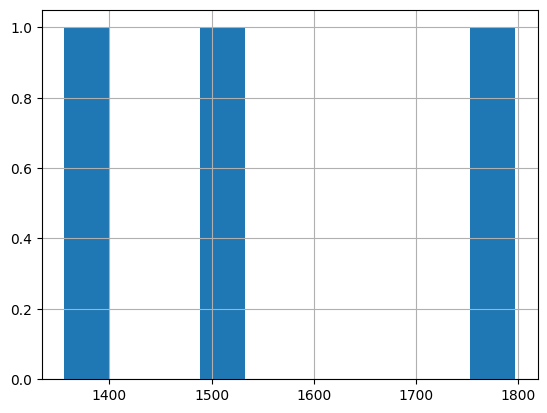

In [13]:
written_LLM['text'].str.len().hist() #string length

Here, we can see that LLMs wrote string length between approximately 1400 and 1800 whereas humans wrote string length essays between 1500 to about 7000.

Humans' essays have more range of string length and the histogram decreases smoothly from 3000 to 7000 whereas the limited sample size of 3 for LLMs shows us that all samples were below a length of 2000 and seem randomized in length.

<Axes: >

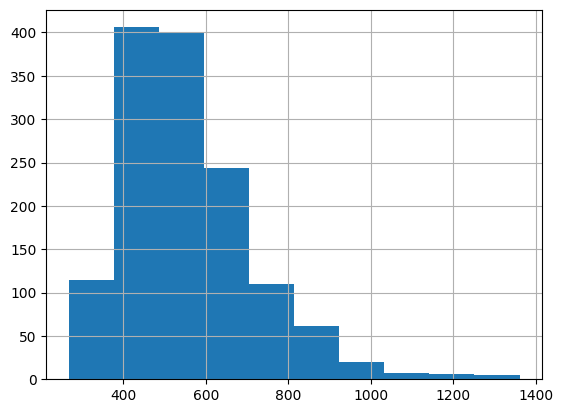

In [14]:
written_human['text'].str.split().map(lambda x: len(x)).hist()#number of words

<Axes: >

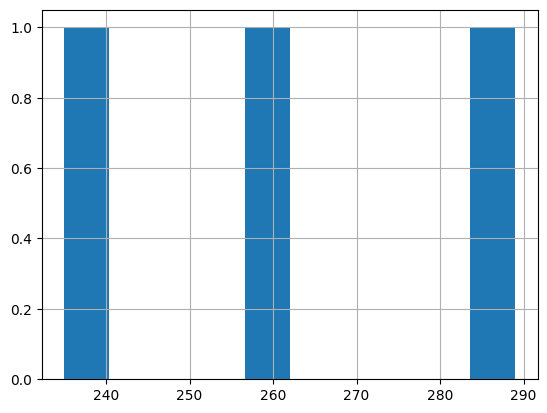

In [15]:
written_LLM['text'].str.split().map(lambda x: len(x)).hist()#number of words

# Preprocessing

In [16]:
train_df, val_df = train_test_split(train, test_size=0.2, random_state=8, stratify=train['generated'])

## Create Tokenizers
In this section, I train tokenizers from scratch by leveraging Hugging Face’s tokenizers package. Here I use the BPE algorithm, Byte Pair Encoding, which uses the frequency of subword patterns in order to create a shorter list for merging. It is able to generate unambiguous tokens.

In [17]:
tk = Tokenizer(models.BPE(unk_token="[UNK]"))
tk.pre_tokenizer = pre_tokenizers.ByteLevel()
tk.normalizer = normalizers.Sequence([normalizers.NFD(), normalizers.Lowercase(),
                                             normalizers.StripAccents()])

trainer = trainers.BpeTrainer(vocab_size=30522, special_tokens=
                              ["[UNK]", "[CLS]", "[SEP]", "[PAD]", "[MASK]"])

data_for_tokenizer_train = train_df['text'].tolist()
tk.train_from_iterator(data_for_tokenizer_train, trainer)

tokenizer = PreTrainedTokenizerFast(
    tokenizer_object=tk,
    sep_token="[SEP]",
    pad_token="[PAD]",
    mask_token="[MASK]",
    unk_token="[UNK]",
    cls_token="[CLS]",
)

train_df['text'] = train_df['text'].apply(
    lambda x: tokenizer.tokenize(x, add_special_tokens=True))

val_df['text'] = val_df['text'].apply(
    lambda x: tokenizer.tokenize(x, add_special_tokens=True))


test['text'] = test['text'].apply(
    lambda x: tokenizer.tokenize(x, add_special_tokens=True))

In [18]:
train

,id,prompt_id,text,generated
0,0059830c,0,Cars. Cars have been around since they became ...,0
1,005db917,0,Transportation is a large necessity in most co...,0
2,008f63e3,0,"""America's love affair with it's vehicles seem...",0
3,00940276,0,How often do you ride in a car? Do you drive a...,0
4,00c39458,0,Cars are a wonderful thing. They are perhaps o...,0
...,...,...,...,...
1373,fe6ff9a5,1,There has been a fuss about the Elector Colleg...,0
1374,ff669174,0,Limiting car usage has many advantages. Such a...,0
1375,ffa247e0,0,There's a new trend that has been developing f...,0
1376,ffc237e9,0,As we all know cars are a big part of our soci...,0


In [19]:
test

,id,prompt_id,text
0,0000aaaa,2,"[Ġa, aa, Ġb, b, b, Ġc, cc, .]"
1,1111bbbb,3,"[Ġb, b, b, Ġc, cc, Ġd, dd, .]"
2,2222cccc,4,"[Ġc, cc, Ġd, dd, Ġe, ee, .]"


# Preprocessing with a TF-IDF Vectorizer

The below textReturn function is for the tokenizer parameter in TfidfVectorizer. It returns the text as is since we already tokenized it.

In [20]:
def textReturn(text):
    return text

vect = TfidfVectorizer(ngram_range=(3, 5), tokenizer=textReturn, preprocessor=textReturn,
                    sublinear_tf=True, token_pattern=None, lowercase=False,
                    min_df=0.001)
vect.fit(train_df['text'])
vocab = vect.vocabulary_
vect = TfidfVectorizer(ngram_range=(3, 5), tokenizer=textReturn, preprocessor=textReturn,
                    sublinear_tf=True, token_pattern=None, lowercase=False,
                    vocabulary=vocab)
X_train = vect.fit_transform(train_df['text']).astype('float32')
X_val = vect.fit_transform(val_df['text']).astype('float32')
X_test = vect.fit_transform(test['text']).astype('float32')

# Model Building

In [21]:
model = Sequential([
    Input(shape=(X_train.shape[1],), sparse=True),
    Dense(32, activation='relu', kernel_initializer='he_normal'),
    Dropout(0.2),
    Dense(64, activation='relu', kernel_initializer='he_normal'),
    Dropout(0.3),
    Dense(32, activation='relu', kernel_initializer='he_normal'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', AUC()])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                4417760   
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 64)                2112      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 3

In [22]:
y_train = train_df['generated'].values
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2)

model.fit(X_train, y_train, batch_size=128, epochs=10, callbacks=[early_stopping])

preds = model.predict(X_val)
print(len(preds))

Epoch 1/10
9/9 [==============================] - 2s 73ms/step - loss: 0.6697 - accuracy: 0.8956 - auc: 0.3027
Epoch 2/10
9/9 [==============================] - 1s 75ms/step - loss: 0.5669 - accuracy: 0.9955 - auc: 0.7336
Epoch 3/10
9/9 [==============================] - 1s 57ms/step - loss: 0.4006 - accuracy: 0.9982 - auc: 0.8216
Epoch 4/10
9/9 [==============================] - 1s 55ms/step - loss: 0.2154 - accuracy: 0.9982 - auc: 0.9089
Epoch 5/10
9/9 [==============================] - 1s 59ms/step - loss: 0.0932 - accuracy: 0.9982 - auc: 0.9764
Epoch 6/10
9/9 [==============================] - 1s 57ms/step - loss: 0.0388 - accuracy: 0.9982 - auc: 0.9830
Epoch 7/10
9/9 [==============================] - 1s 62ms/step - loss: 0.0176 - accuracy: 0.9982 - auc: 0.9973
Epoch 8/10
9/9 [==============================] - 1s 55ms/step - loss: 0.0121 - accuracy: 0.9982 - auc: 0.9936
Epoch 9/10
9/9 [==============================] - 1s 59ms/step - loss: 0.0076 - accuracy: 0.9982 - auc: 0.9970
E

In [23]:
y_val = val_df['generated'].values
auc_score = roc_auc_score(y_val, preds)
print(auc_score)

0.9963636363636363


In [24]:
preds = model.predict(X_test)
print(preds)

1/1 [==============================] - 0s 10ms/step
[[0.20093432]
 [0.20093432]
 [0.20093432]]


In [25]:
submission['generated'] = preds

In [26]:
submission

,id,generated
0,0000aaaa,0.200934
1,1111bbbb,0.200934
2,2222cccc,0.200934


In [27]:
submission.to_csv('submission.csv', index=False)